In [1]:
from dap_job_quality import BUCKET_NAME, PRINZ_BUCKET_NAME
from dap_job_quality.getters.data_getters import load_s3_data, load_s3_excel, save_to_s3
from dap_job_quality.getters.ojo_getters import get_ojo_sample, get_ojo_salaries_sample, get_ojo_job_title_sample

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.metrics.distance import edit_distance

import ast

2024-02-21 16:31:29,666 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


This notebook compares how salary data from OJO compares to salary data from the Annual Survey of Hours and Earnings (ASHE). These are released in November each year, and cover the previous FY. . 
It compares to three tables from the ASHE:

- Table 2: Earnings and hours worked, occupation by two-digit SOC (https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/occupation2digitsocashetable2)
- Table 3: Earnings and hours worked, region by two-digit SOC (https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/regionbyoccupation2digitsocashetable3)
- Table 14: Earnings and hours worked, 4 digit SOC (https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/earningsandhoursworkedallemployeesashetable14)


The data is downloaded from the ONS website and manually placed in an S3 bucket (current s3 links below)

## ASHE-related variables to set

In [2]:
YEAR_OF_PUBLICATION = 2023 #The year the current ASHE tables were published

#ASHE data paths - saved manually into the S3 bucket (from the ONS website)
table_2_path = 'job_quality/ashe_data/2023/PROV - Occupation SOC20 (2) Table 2.7a   Annual pay - Gross 2023.xls'
table_3_path = 'job_quality/ashe_data/2023/PROV - Work Region Occupation SOC20 (2) Table 3.7a   Annual pay - Gross 2023.xls'
table_14_path = 'job_quality/ashe_data/2023/PROV - Occupation SOC20 (4) Table 14.7a   Annual pay - Gross 2023.xls'

## Load and clean data

In [3]:
#Load OJO data file (created using dap_job_quality/utils/create_df_for_salary_analysis.py)

clean_df = load_s3_data(BUCKET_NAME, 'job_quality/salary_analysis/salary_analysis_df.csv')

#Filter for just the relevant ASHE period (change to relevant year)

ojo_df_23 = clean_df[(clean_df['created'] >= f'{YEAR_OF_PUBLICATION -1 }-03-31') & (clean_df['created'] <= f'{YEAR_OF_PUBLICATION}-03-31')]

print(f'All records: {len(clean_df)}')
print(f'2022-23 records: {len(ojo_df_23)}')

2024-02-21 16:31:30,653 - aiobotocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
All records: 4653782
2022-23 records: 1142076


In [4]:
#Function for cleaning ONS data file

#Clean ONS tables
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Takes an ASHE excel sheets and returns a clean dataframe.
    Note: This function is specific to the ASHE excel sheet format as of 2023, but will work across multiple tables (2,3, 14)
    """    
    # Find the column location where every value is NaN
    nan_columns = df.columns[df.isna().all()]

    # Remove columns to the right-hand side
    df = df.drop(columns=df.columns[df.columns.get_loc(nan_columns[-1]):])

    # Rename column headers
    column_names = ['Title', 'SOC_code', 'Number of jobs (thousand)', 'Median_gross_pay',
        'Annual percentage change', 'Mean_gross_pay',
        'Annual percentage change.1', '10th percentile', '20th percentile',
        '25th percentile', '30th percentile', '40th percentile',
        '60th percentile', '70th percentile', '75th percentile',
        '80th percentile', '90th percentile']

    columns_dict = {i: column_names[i] for i in range(len(column_names))}

    df.columns = columns_dict.values()

    df.set_index(keys='Title', inplace=True)

    # Drop header rows
    df = df.drop(index=[np.nan, 'Description'])

    # Replace 'x' and ':' missing values with NaN
    df.replace(['x', ':', '..'], np.nan, inplace=True)

    # Drop rows where every value is nan
    clean_df = df.dropna(how='all')
    
    #Assign all variables as float (except SOC_code)
    
    clean_df.astype({col: float for col in clean_df.columns if col != 'SOC_code'})

    return clean_df
    

In [5]:
#Load and clean ONS data

ons2 = clean_dataframe(load_s3_excel(BUCKET_NAME, table_2_path, sheet_name='All'))
ons14 = clean_dataframe(load_s3_excel(BUCKET_NAME,table_14_path, sheet_name='All'))
ons3 = clean_dataframe(load_s3_excel(BUCKET_NAME,table_3_path, sheet_name='All'))

## OJO-only plots

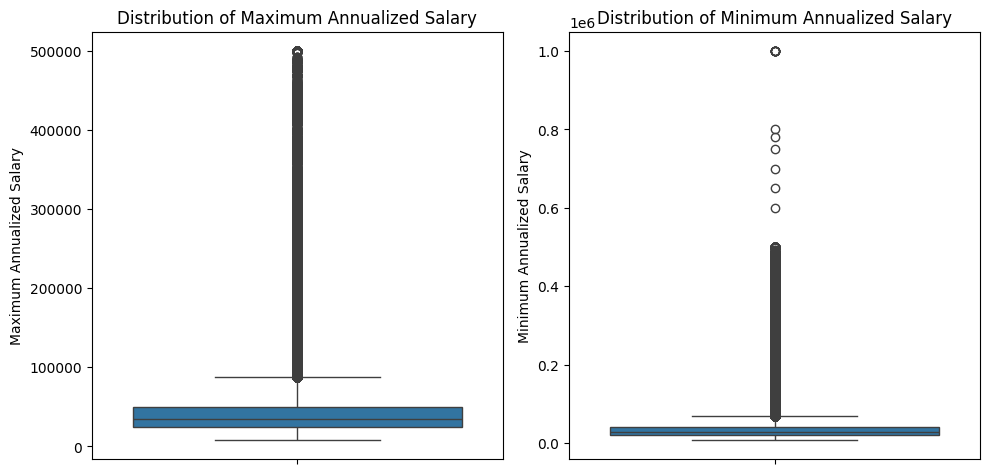

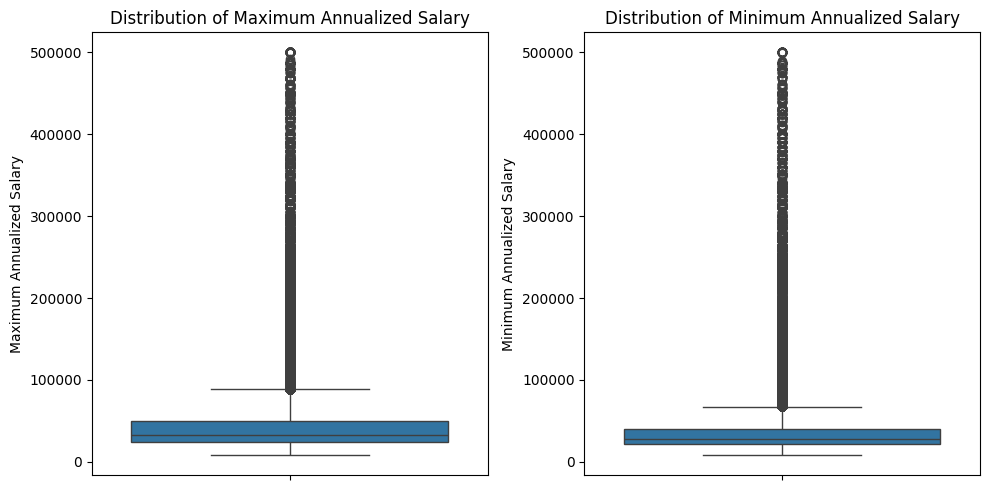

In [6]:
def plot_salary_distribution(df):
    '''Creates a boxplot of the minimum and maximum annalised salary in the dataframe'''
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the maximum annualized salary
    sns.boxplot(data=df, y='max_annualised_salary', ax=axes[0])
    axes[0].set_title('Distribution of Maximum Annualized Salary')
    axes[0].set_ylabel('Maximum Annualized Salary')

    # Plot the minimum annualized salary
    sns.boxplot(data=df, y='min_annualised_salary', ax=axes[1])
    axes[1].set_title('Distribution of Minimum Annualized Salary')
    axes[1].set_ylabel('Minimum Annualized Salary')

    # Adjust the layout and display the plots
    plt.tight_layout()
    plt.show()

#Plot for all data
plot_salary_distribution(clean_df)

#Plot for the relevant year of data
plot_salary_distribution(ojo_df_23)

## Mean and median annual pay, ONS and OJO, all employees/ occupations/ regions

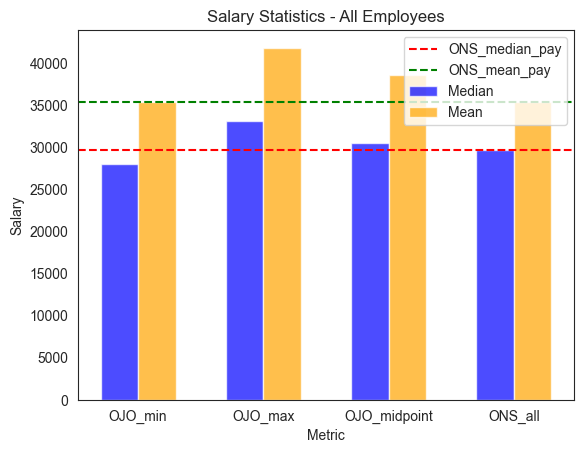

In [7]:

def calculate_overall_stats(ojo_df, ons_df_2):
    """Function takes the OJO and ONS Table 2 dataframes, and returns
        the mean and median  in salary for:
                - ASHE All employees
                - OJO minimum salary
                - OJO maxiumum salary
                - OJO midpoint salary
    """    
    min_annualised_salary_median = ojo_df['min_annualised_salary'].median()
    min_annualised_salary_mean = ojo_df['min_annualised_salary'].mean()

    max_annualised_salary_median = ojo_df['max_annualised_salary'].median()
    max_annualised_salary_mean = ojo_df['max_annualised_salary'].mean()

    mean_salary_median = ojo_df['mean_salary'].median()
    mean_salary_mean = ojo_df['mean_salary'].mean()

    # Create a dataframe to store the results
    salary_stats_df = pd.DataFrame({
        'Metric': ['OJO_min', 'OJO_max', 'OJO_midpoint'],
        'Median': [min_annualised_salary_median, max_annualised_salary_median, mean_salary_median],
        'Mean': [min_annualised_salary_mean, max_annualised_salary_mean, mean_salary_mean]
    })

    # Append ONS statistics to salary_stats_df
    ONS_all = pd.DataFrame({'Metric': ['ONS_all'], 'Median': [ons_df_2.loc['All employees', 'Median_gross_pay']], 'Mean': [ons_df_2.loc['All employees', 'Mean_gross_pay']]})

    salary_stats_df = pd.concat([salary_stats_df, ONS_all]).round().set_index('Metric')
    
    
    #Plot the results
    
    # Set the style of the plot
    sns.set_style("white")

    # Create a bar chart from the results
    fig, ax = plt.subplots()
    x = range(len(salary_stats_df))
    width = 0.3

    # Plot the bars for OJO data
    ax.bar(x, salary_stats_df['Median'], width, color='blue', alpha=0.7, label='Median')
    ax.bar([i + width for i in x], salary_stats_df['Mean'], width, color='orange', alpha=0.7, label='Mean')

    # Add a line at ONS median, mean values
    ax.axhline(y=salary_stats_df.loc['ONS_all', 'Median'], color='red', linestyle='--', label='ONS_median_pay')
    ax.axhline(y=salary_stats_df.loc['ONS_all', 'Mean'], color='green', linestyle='--', label='ONS_mean_pay')

    ax.set_xlabel('Metric')
    ax.set_ylabel('Salary')
    ax.set_title('Salary Statistics - All Employees')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(salary_stats_df.index)  # Exclude the last index (ONS)
    ax.legend()

    plt.show()
    
    

    return salary_stats_df

 
        
mean_median_df = calculate_overall_stats(ojo_df_23, ons2)


## 4-digit SOC comparison, ONS to OJO

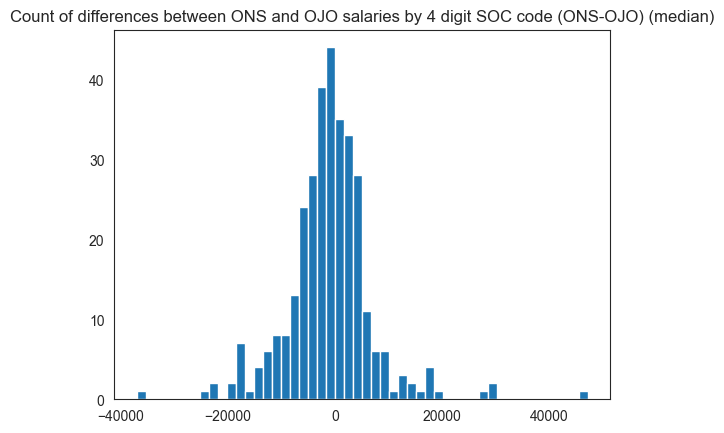

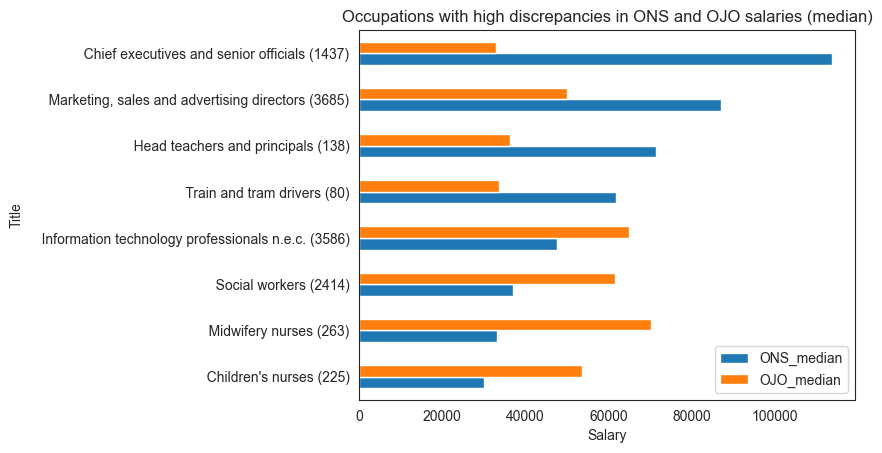

In [8]:
def check_soc_4_digit(ojo_df, ons_df_14,discrepancy_threshold=20000, metric_type = 'mean'):
    """Gets the differences between ONS and OJO data by SOC 4, on average and for large discrepancy occupations

    Args:
        ojo_df (Dataframe): The current OJO data
        ons_df_14 (Dataframe): ASHE Table 14, cleaned data
        discrepancy_threshold (int, optional): If the difference in mean/ median salaries is greater than this, occupations will be in the bar chart. Defaults to £20000.
        metric_type (str, optional): Whether to use 'mean' or 'median' salaries for each occupation for comparison. Defaults to 'mean'.

    Returns:
        _type_: _description_
    """    '''Finds the difference between the mean or median salary in the ONS and OJO dataframes for each 4 digit SOC code'''
    
    ons_df_14 = ons_df_14.reset_index()
    
    #Group ojo data by SOC 4 digit (median salary)
    ons_df_14['SOC_code'] = ons_df_14['SOC_code'].astype(float)

    if metric_type == 'mean':
        ojo4digit = ojo_df[['mean_salary', 'min_annualised_salary', 'max_annualised_salary', 'SOC_4digit']].groupby('SOC_4digit').mean()
        ojo4digit['record_count'] = ojo_df[['mean_salary', 'SOC_4digit']].groupby('SOC_4digit').count()
        ojo4digit = ojo4digit.merge(ons_df_14[['Title','SOC_code', 'Median_gross_pay', 'Mean_gross_pay']], left_on = 'SOC_4digit', right_on = 'SOC_code', how  = 'left')
        ojo4digit['sal_diff_ons_to_ojo'] = ojo4digit['Mean_gross_pay'] - ojo4digit['mean_salary']
    else:
        ojo4digit = ojo_df[['mean_salary', 'min_annualised_salary', 'max_annualised_salary', 'SOC_4digit']].groupby('SOC_4digit').median()
        ojo4digit['record_count'] = ojo_df[['mean_salary', 'SOC_4digit']].groupby('SOC_4digit').count()
        ojo4digit = ojo4digit.merge(ons_df_14[['Title','SOC_code', 'Median_gross_pay', 'Mean_gross_pay']], left_on = 'SOC_4digit', right_on = 'SOC_code', how  = 'left')
        ojo4digit['sal_diff_ons_to_ojo'] = ojo4digit['Median_gross_pay'] - ojo4digit['mean_salary']
    
    #Plot the histogram of all differences
    plt.hist(ojo4digit['sal_diff_ons_to_ojo'], bins = 50)
    plt.title('Count of differences between ONS and OJO salaries by 4 digit SOC code (ONS-OJO) ({})'.format(metric_type))
    
    plt.show()
    
    #Get occupations with highest differences
    
    big_discrepancy = ojo4digit[abs(ojo4digit['sal_diff_ons_to_ojo']) > int(discrepancy_threshold)]
    big_discrepancy = big_discrepancy.sort_values('Mean_gross_pay', ascending=True)

    # Add brackets with record count to the title
    big_discrepancy['Title_with_count'] = big_discrepancy['Title'] + ' (' + big_discrepancy['record_count'].astype(str) + ')'

    big_discrepancy.plot(x='Title_with_count', y=['Mean_gross_pay', 'mean_salary'], kind='barh')
    plt.xlabel('Salary')
    plt.ylabel('Title')
    plt.title('Occupations with high discrepancies in ONS and OJO salaries ({})'.format(metric_type))
    plt.legend([f'ONS_{metric_type}', f'OJO_{metric_type}'])
    plt.show()
    
    return ojo4digit

soc_4_df = check_soc_4_digit(ojo_df_23, ons14, 20000, 'median')

## Regional comparison, ONS to OJO

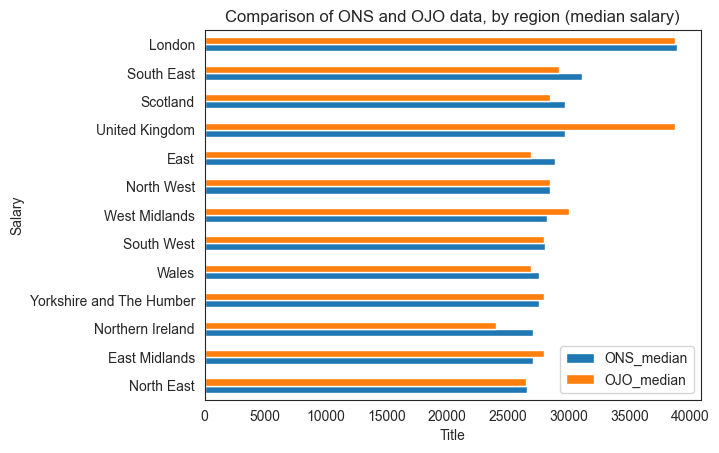

,Title,SOC_code,Number of jobs (thousand),Median_gross_pay,Annual percentage change,Mean_gross_pay,Annual percentage change.1,10th percentile,20th percentile,25th percentile,30th percentile,40th percentile,60th percentile,70th percentile,75th percentile,80th percentile,90th percentile,best_match,itl_1_name,mean_salary
1,North East,E12000001,862.0,26576.0,6.2,29706.0,4.6,9751.0,15396.0,18172.0,20166.0,23356.0,30333.0,35020.0,37875.0,40974.0,49676.0,North East,North East,26500.00
4,East Midlands,E12000004,1519.0,27062.0,4.8,30686.0,4.5,9600.0,15279.0,18132.0,20391.0,23813.0,30801.0,35411.0,38367.0,42042.0,52587.0,East Midlands,East Midlands,28000.00
12,Northern Ireland,N92000002,903.0,27102.0,6.6,31794.0,7.1,9783.0,15507.0,18335.0,20398.0,23908.0,31485.0,36775.0,40056.0,43135.0,54412.0,Northern Ireland,Northern Ireland,24000.00
3,Yorkshire and The Humber,E12000003,1747.0,27528.0,6.4,31283.0,4.8,10155.0,16285.0,18944.0,21078.0,24399.0,31500.0,36298.0,39416.0,42503.0,53690.0,Yorkshire and the Humber,Yorkshire and the Humber,28000.00
10,Wales,W92000004,1020.0,27571.0,6.5,30101.0,5.9,9949.0,16011.0,18759.0,21001.0,24215.0,31378.0,36249.0,39296.0,42210.0,50470.0,Wales,Wales,26910.00
9,South West,E12000009,1894.0,28059.0,6.6,31801.0,7.0,9811.0,16167.0,18878.0,21115.0,24576.0,32283.0,37168.0,40469.0,43706.0,54745.0,South West,South West,28000.00
5,West Midlands,E12000005,1895.0,28192.0,6.2,32649.0,7.1,9885.0,16055.0,18975.0,21233.0,24666.0,32314.0,37673.0,40478.0,43666.0,54125.0,West Midlands,West Midlands,30000.00
2,North West,E12000002,2356.0,28506.0,8.9,32404.0,6.9,10583.0,16875.0,19715.0,21626.0,25000.0,32787.0,37749.0,40888.0,44460.0,55429.0,North West,North West,28500.00
6,East,E12000006,1985.0,28883.0,7.8,32817.0,5.2,8625.0,14379.0,17403.0,20329.0,24814.0,33335.0,38700.0,42257.0,45898.0,58128.0,Wales,Wales,26910.00
0,United Kingdom,K02000001,22480.0,29669.0,6.8,35404.0,5.8,10186.0,16815.0,19783.0,21970.0,25802.0,34303.0,40000.0,43157.0,47248.0,60506.0,London,London,38795.25


In [9]:
# Create a function to find the best match for each region name
def find_best_match(region_name, region_names):
    '''The ASHE and OJO files have slightly different ITL names, helper function to match them'''
    best_match = min(region_names, key=lambda x: edit_distance(region_name, x))
    return best_match
    

def compare_regions(ojo_df, ons_df_3, metric_type='mean'):
    # Filter ONS table for ITL regions
    ons_region = ons_df_3[ons_df_3['SOC_code'].str.contains('[a-zA-Z]')].reset_index()

    # Group OJO df into regions
        
    if metric_type == 'mean':
            ojo_region = ojo_df['mean_salary'].groupby(ojo_df['itl_1_name']).mean().reset_index()
    elif metric_type == 'median':
        ojo_region = ojo_df['mean_salary'].groupby(ojo_df['itl_1_name']).median().reset_index()
    else:
        print ("Select valid metric type: 'mean' or 'median'")
        return
        
    #Match ONS and OJO region names
    ojo_region['itl_1_name'] = ojo_region['itl_1_name'].str.replace(r'\(England\)', '', regex=True) # Remove (England) from OJO region names

    ons_region['best_match'] = ons_region['Title'].apply(lambda x: find_best_match(x, ojo_region['itl_1_name'])) #Get best match

    # Join ons_region and ojo_region based on the best match
    merged_data = ons_region.merge(ojo_region, left_on='best_match', right_on='itl_1_name', how='left')
        
    if metric_type == 'mean':
        merged_data = merged_data.sort_values('Mean_gross_pay', ascending=True)
        ax = merged_data.plot(x='Title', y=['Mean_gross_pay', 'mean_salary'], kind='barh')
        ax.set_xlabel('Title')
        ax.set_ylabel('Salary')
        ax.set_title('Comparison of ONS and OJO data, by region (median salary)')
        ax.legend(['ONS_mean', 'OJO_mean'])
        plt.show()
    else:
        merged_data = merged_data.sort_values('Median_gross_pay', ascending=True)
        ax = merged_data.plot(x='Title', y=['Median_gross_pay', 'mean_salary'], kind='barh')
        ax.set_xlabel('Title')
        ax.set_ylabel('Salary')
        ax.set_title('Comparison of ONS and OJO data, by region (median salary)')
        ax.legend(['ONS_median', 'OJO_median'])
        plt.show()
    
    return merged_data

# Call the function
compare_regions(ojo_df_23, ons3, 'median')


